### Інструкція

Перший раз запустити код з допомогою кнопки 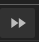

Для повторної роботи з кодом, достатньо перезапустити останній блок коду `if __name__ == "__main__": main()`

1. Обрати файл, дані якого потрібно змінити
2. Обрати лист з потрібними даними
3. Обрати опцію для кожного зі стовпців
4. Обрати куди зберегти результати:
   * створити новий файл:
     <br>написати назву файлу -> написати назву листа (sheet)
     <br>ФАЙЛ СТВОРЮЄТЬСЯ НА РОБОЧОМУ СТОЛІ

   * зберегти результати в існуючому файлі:
     <br>ФАЙЛ, В ЯКОМУ БУДЕ ЗБЕРЕЖЕНО РЕЗУЛЬТАТИ, МАЄ БУТИ ЗАКРИТИМ
     <br>вибрати файл, в якому буде збережено результати -> написати назву листа (sheet)

### Imports and general

In [1]:
# pip install pandas
# pip install numpy
# pip install tkinter
# pip install openpyxl
# pip install XlsxWriter

In [2]:
import os
import pandas as pd
import numpy as np

import datetime
import tkinter as tk
from tkinter import ttk, Tk, Toplevel, Listbox, Button, SINGLE, END, Label, Radiobutton, StringVar, messagebox, simpledialog
from tkinter.filedialog import askopenfilename, asksaveasfilename

from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows

In [3]:
def ask_string_value(title):
    root = tk.Tk()
    root.withdraw()

    string_value = simpledialog.askstring("Excel Sheet Name", title)
    print(f'string_value = {string_value}')
    if string_value:
        return string_value.strip()
    else:
        messagebox.showerror('Error', 'No sheet name was entered') 
        return None

### Load a file

In [4]:
def choose_filename():
    Tk().withdraw()

    filename = askopenfilename(
        title="Select an Excel file",
        filetypes=[("Excel files", "*.xlsx *.xls")]
    )
    return filename


def select_sheet(sheet_names):
    top = Toplevel()
    top.title("Select a sheet")
    top.geometry('600x600')
    
    listbox = Listbox(top, selectmode=SINGLE)
    for sheet in sheet_names:
        listbox.insert(END, sheet)
    listbox.pack(padx=10, pady=10)

    selected_sheet = []

    def on_select():
        selection = listbox.curselection()
        if selection:
            selected_sheet.append(sheet_names[selection[0]])
        top.destroy()

    button = Button(top, text="Select", command=on_select)
    button.pack(pady=5)

    top.wait_window(top)
    return selected_sheet[0] if selected_sheet else None


def read_excel_file(filename, sheet_name):
    df = pd.read_excel(filename, sheet_name=sheet_name) 
    df.columns = map(str.lower, df.columns)
    print('Excel file selected')
    return df

In [5]:
def get_raw_data():
    file_path = choose_filename()
    
    if file_path:
        xls = pd.ExcelFile(file_path)
        sheet_name = select_sheet(xls.sheet_names)

        if sheet_name in xls.sheet_names:
            df = read_excel_file(file_path, sheet_name)
            print("DataFrame loaded successfully.")
            df = df.fillna(0)
            return df
        else:
            messagebox.showerror('Error', "Invalid sheet name selected.")
    else:
        messagebox.showerror('Error', "No file selected.") 

### Select "Divide" or "Duplicate"

In [6]:
def select_options(df):
    def submit():
        root.withdraw()
        root.quit()

    def on_radio_click(var, value):
        var.set(value)
    
    def transform_results():
        results_dict = {col: choice.get() for col, choice in results.items()}
        return results_dict
    
    root = tk.Tk()
    root.title('Select option')
    results = {}

    numeric_columns = df.select_dtypes(include='number')
    num_cols_to_show = [col for col in numeric_columns if 'year' not in col and 'month' not in col]
    
    for idx, col in enumerate(num_cols_to_show):
        label = Label(root, text=f'{col}:')
        label.grid(row=idx, column=0, padx=10, pady=5)
        
        var = StringVar(value='Duplicate')
        results[col] = var
        
        duplicate_button = ttk.Radiobutton(root, text='Duplicate', variable=var, value='Duplicate', command=lambda v=var: on_radio_click(v, "Duplicate"))
        duplicate_button.grid(row=idx, column=1, padx=10, pady=5)
    
        divide_button = ttk.Radiobutton(root, text='Divide', variable=var, value='Divide', command=lambda v=var: on_radio_click(v, "Divide"))
        divide_button.grid(row=idx, column=2, padx=10, pady=5)
    
    submit_button = Button(root, text='Submit', command=submit)
    submit_button.grid(row=len(numeric_columns), columnspan=3, pady=10)
    
    root.mainloop()
    return transform_results()

### Create new df with weeks

In [7]:
def create_year_week_df(start_year, end_year, last_month):
    data = {'year': [], 'month': [], 'week': []}
    
    for year in range(start_year, end_year + 1):
        if year != end_year:
            last_week = datetime.date(year, 12, 28).isocalendar()[1]
        else:
            last_week = datetime.date(year, last_month, 28).isocalendar()[1]

        for week in range(1, last_week + 1):
            data['year'].append(year)
            data['month'].append(get_dominant_month(year, week))
            data['week'].append(week)
        
    df = pd.DataFrame(data)
    return df


def get_dominant_month(year, week):
    days_in_week = [datetime.date.fromisocalendar(year, week, day) for day in range(1, 8)]
    months = [day.month for day in days_in_week]
    dominant_month = max(set(months), key=months.count)
    return dominant_month

### Get df with results

In [8]:
def get_weekly_df(week_df, month_df, seleted_options):
    res_df = pd.merge(week_df, month_df, on=['year', 'month'], how='left')
    divide_cols = get_divide_col_list(seleted_options)
    for col in divide_cols:
        res_df[col] = res_df.groupby(['year', 'month'])[col].transform(lambda x: x / len(x))
    return res_df


def get_divide_col_list(seleted_options):
    divide_cols = []
    for col, choise in seleted_options.items():
        if choise == 'Divide':
            divide_cols.append(col)
    print(divide_cols)
    return divide_cols

In [9]:
def create_weekly_df(raw_data):
    first_year = raw_data['year'].min()
    last_year = raw_data['year'].max()
    last_month = raw_data[raw_data['year'] == last_year]['month'].max()
    weekly_df = create_year_week_df(first_year, last_year, last_month)
    return weekly_df

### Choose "Create Excel file" or "Save to existing file"

In [10]:
def select_unique_option(options, title):    
    def on_selected():
        root.destroy()

    root = Toplevel()
    root.title(title)
    root.geometry('600x600')

    selected_option = StringVar(value=options[0])
    for option in options:
         radio_button = tk.Radiobutton(root, text=option, variable=selected_option, value=option)
         radio_button.pack(anchor='w')
    
    select_button = tk.Button(root, text="Select", command=on_selected)
    select_button.pack()
    root.wait_window()

    return selected_option.get()

In [11]:
def select_how_to_save_results():
    options = ['Create Excel file', 'Save to existing file']
    title = 'I want to...'
    selected_option = select_unique_option(options, title)
    return selected_option

### Create new Excel file

In [12]:
def ask_file_name():
    title = "Enter file name:"
    file_name = ask_string_value(title) + '.xlsx'
    return file_name
    

def create_new_excel_file():
    file_name = ask_file_name()
    print(f'name = {file_name}')
    desktop_path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')
    print(f'path - {desktop_path}')
    file_path = os.path.join(desktop_path, file_name)
    return file_path

### Write to existing Excel file

In [13]:
def get_file_path():
    root = tk.Tk()
    root.withdraw()

    file_path = askopenfilename(
        defaultextension=".xlsx",
        filetypes=[("Excel files", "*.xlsx"), ("All files", "*.*")],
        title="Select Excel File"
    )

    if not file_path:
        messagebox.showerror('Error', 'No file selected')
    return file_path


def ask_sheet_name():
    title = "Enter sheet name:"
    sheet_name = ask_string_value(title)
    return sheet_name

In [14]:
def write_to_excel(file_path, df, sheet_name):
    first_row = 1
    
    if os.path.exists(file_path):
        wb = load_workbook(file_path)
        if sheet_name in wb.sheetnames:
            sheet = wb[sheet_name]
        else:
            sheet = wb.create_sheet(sheet_name)

        for row_idx, row in enumerate(dataframe_to_rows(df, index=False, header=True), start=first_row):
            for col_idx, value in enumerate(row, start=1):
                sheet.cell(row=row_idx, column=col_idx, value=value)
        wb.save(file_path)
        
    else:
        with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
            df.to_excel(writer, sheet_name=sheet_name, index=False, startrow=first_row)

In [15]:
def manage_excel_sheets(df):
    res = select_how_to_save_results()

    file_path = ''
    sheet_name = ''
    if res == 'Create Excel file':
        file_path = create_new_excel_file()
        sheet_name = ask_sheet_name()
    elif res == 'Save to existing file':
        file_path = get_file_path()
        sheet_name = ask_sheet_name()
        
    write_to_excel(file_path, df, sheet_name)

### Main function

In [16]:
def main():
    raw_data = get_raw_data()
    selected_options = select_options(raw_data)
    
    weekly_df = create_weekly_df(raw_data)
    result_df = get_weekly_df(weekly_df, raw_data, selected_options)

    manage_excel_sheets(result_df)
    messagebox.showinfo("Congratulation!", "Data transformed and saved :)") 

In [17]:
if __name__ == "__main__":
    main()

Excel file selected
DataFrame loaded successfully.
['youtube', 'display', 'telegram', 'pr', 'ooh']
string_value = trtrtrtr
